### Imports

In [2]:
import numpy as np
from scipy.interpolate import CubicSpline, interp1d, make_interp_spline, UnivariateSpline
from scipy.optimize import newton, fsolve
import matplotlib.pyplot as plt
import bond_pricing as bp
# from sympy import *

### Generalized Bootstrap Method to Determine the Yield Curve

#### Model Introduction

If an analyst were able to possess a sufficient quantity of reliable friction-free government bond data, a technique known as the bootstrap would straightforwardly derive the spot yield curve. This technique is based on the notion that individual coupon-paying bonds can be viewed as “packages” of pure discount bonds. For example, a three-year bond is comprised of six pure discount bonds, namely the five coupon payments to be paid every six months, and the final payment which is the sum of the final coupon and the return of principal. This suggests that a bond’s value can be viewed as either the present value of future cash flows discounted at the yield to maturity, or as the sum of the values of individual pure discount bonds, each of which is a present value of a cash flow discounted at its own time-specific yield.

The classic “textbook” explication of the bootstrap usually begins by assuming the existence of a set of perfectly spaced bonds: for example, a 6-month, a 12-month, an 18-month and so on. If these bonds have frictionless market prices, the bootstrap renders the correct yield curve in a straightforward fashion, as will be illustrated below.

The problem with the bootstrap is that it relies heavily on the existence of a suitable body of data. In particular there are two problems: **illiquidity** and **missing data points**. Quotes coming from a thin market may be at divergence from true market prices due to spreads and asynchronous trading. This is why applying the bootstrap to a raw sample of bonds is likely to lead to an unreasonably “choppy” yield curve. One approach is to perform some form of curve fitting to arrive at a reasonably smooth representation of the yield curve. This can be done either before or after utilizing the bootstrap. Nevertheless there is a problem with any smoothing procedure which is unavoidable: the final curve will always be a function of an assumed functional form. For example, the Nelson and Siegel procedure allows for a single hump while the Svensson approach allows for two humps.

There is another approach for eliminating inappropriate shapes, namely to make use of **averaged yield data**. For example, one could take all bonds in the neighborhood of the five-year maturity, average their yields and then use the **resultant average as the yield on a hypothetical five-year par bond in the belief that some of the bonds comprising the average will be discount bonds and others will be premium bonds**. This, in fact, will be the approach that we will employ in some examples discussed later.

As for the second problem with the bootstrap — the lack of a full set of data — this must be solved by imposing conditions on the intermediate points. Of course, one can never avoid the arbitrariness of the choice of various interpolation procedures. We argue below that a **cubic spline** is an appropriate choice.

The procedure described below is a generalized bootstrapping method. Using python to construct and solve for algebraic expressions, it straightforwardly deals with any data set regardless of time spacing. **Different interpolation assumptions can be accommodated**. The **illiquidity issue is dealt with by using highly liquid T-bills at the short end of the maturity and average yields beyond one year**. 

More specifically, beginning with a series of bond value expressions for a given set of fixed income securities, one cannot — except under ideal conditions — solve for the yields corresponding to all payment dates, since there are more unknowns than equations. Each maturity date is accounted for by a single bond value expression. Generating equations for the points corresponding to the coupon dates, however, requires the use of an interpolation approach that involves the combination of bond value expression along with an interpolation function. By using SciPy's interpolation and optimization subpackages, it becomes possible to generate inputs, perform interpolation (linear and non-linear) and solve for bond price equations (non-linear) to obtain the points on the yield curve.

A key advantage of our approach is its simple “one-shot” nature. Unlike the methods used by McCulloch, Vasicek and Fong, and Svensson who make a *priori* assumptions about the form of the yield curve, we let the available data determine the exact form of the yield curve by solving a system of nonlinear equations. It is worth stressing that our simpler — yet, general — method requires the structuring of linear and non-linear interpolation functions and bond pricing equations in a way such that the system of equations can be solved using a root-finding algorithm.

#### The Textbook Bootstrap

The bootstrap method — as discussed in standard texts — is used to solve sequentially a system of nonlinear equations which has at least one equation whose solution for a single unknown can be obtained in a straightforward manner. In this section we provide a brief review of the bootstrap method by utilizing a numerical example. The data on the maturity, coupons and prices of four bonds are given below.

**First Example**

| Bond No. | Time to Maturity (Years) | Annual Coupon (Dollars) | Bond Price (Dollars) |
| -------- | ------------------------ | ----------------------- | -------------------- |
| 1        | 0.50                     | 0                       | 94.90                |
| 2        | 1.00                     | 0                       | 90.00                |
| 3        | 1.50                     | 8                       | 96.00                |
| 4        | 2.00                     | 12                      | 101.60               |

* **Note**: We will be using continuously compounding yields in all cases 
* **Coupons**: Coupons are paid semi-annually

$$PV = FV \times e^{-rt}$$
$$r = \ln\left(\frac{FV}{PV}\right) \times \frac{1}{t}$$

Denoting the discount rate for a maturity of $t$ years by $r_{t}$, we can use $t = 0.50$ and $t = 1.00$ to solve $94.9 = 100e^{-r_{0.50}\times 0.5}$ and $90.0 = 100e^{-r_{1.00}\times 1.0}$ and obtain $r_{0.50} = 0.1047$ and $r_{1.00} = 0.1054$, respectively.

In [3]:
years = np.array([0.5, 1.0, 1.5, 2.0])
coupon = np.array([0, 0, 8, 12])
price = np.array([94.90, 90.00, 96.00, 101.60])
face = np.full(4, 100)
freq = 2

r1 = np.log(100/price[0]) / 0.5
r2 = np.log(100/price[1]) / 1.0

In [4]:
# Securities maturing in 0.5y and 1y are zero-coupons
cc_ytm = [r1, r2]

for i in range(2, len(coupon)):
    pv_cf = np.sum(np.full(int(years[i]*freq)-1, coupon[i]/freq) * np.exp(-np.array(cc_ytm) * years[:i]))
    cc_ytm.append(np.log((100 + coupon[i]/freq)/(price[i] - pv_cf)) / years[i])

cc_ytm = np.array(cc_ytm)
print("Implied Spot Rates (c.c.) = ",cc_ytm)

Implied Spot Rates (c.c.) =  [0.10469296 0.10536052 0.10680926 0.10808028]


In [5]:
# Using Discount Factors
df = [price[0]/100, price[1]/100]

for i in range(2, len(coupon)):
    pv_cf = np.sum(np.full(int(years[i]*freq)-1, coupon[i]/freq) * np.array(df))
    df.append((price[i] - pv_cf) / (100 + coupon[i]/freq))
    
df = np.array(df)
print("Discount Factors = ",df)

spots = df**-(1/years) - 1
print("Implied Spot Rates (s.a.) = ",spots)

spots_cc = np.log(1/df) / years
print("Implied Spot Rates (c.c.) = ",spots_cc)

Discount Factors =  [0.949      0.9        0.85196154 0.80560595]
Implied Spot Rates (s.a.) =  [0.11036963 0.11111111 0.112722   0.11413718]
Implied Spot Rates (c.c.) =  [0.10469296 0.10536052 0.10680926 0.10808028]


For the third bond which matures in 1.5 years there are three payments of $4, $4 and $104 at t = 0.50, 1:00 and 1.50, respectively. Since the discount rates at t = 0.50 and 1.00 are already available from the previous calculations, the rate $r_{1.50}$ for $t = 1.50$ can be computed by solving $96 = 4e^{-0.1047\times 0.5} + 4e^{-0.1054\times 1.0} + 4e^{-r\times 1.5}$ for $r_{1.50}$ which gives $r_{1.50} = 0.1086$. In a similar fashion, it is straightforward to calculate $r_{2.00}= 0.1081$.

**Second Example**

| Bond No. | Time to Maturity (Years) | Annual Coupon (Dollars) | Bond Price (Dollars) |
| -------- | ------------------------ | ----------------------- | -------------------- |
| 1        | 0.50                     | 0                       | 99.00                |
| 2        | 1.00                     | 0                       | 97.80                |
| 3        | 1.50                     | 4                       | 102.50               |
| 4        | 2.00                     | 5                       | 105.00               |

In [6]:
years = np.array([0.5, 1.0, 1.5, 2.0])
coupon = np.array([0, 0, 4, 5])
price = np.array([99, 97.80, 102.50, 105.00])
face = np.full(4, 100)
freq = 2

r1 = np.log(100/price[0]) / 0.5
r2 = np.log(100/price[1]) / 1.0

In [7]:
# Securities maturing in 0.5y and 1y are zero-coupons
cc_ytm = [r1, r2]

for i in range(2, len(coupon)):
    pv_cf = np.sum(np.full(int(years[i]*freq)-1, coupon[i]/freq) * np.exp(-np.array(cc_ytm) * years[:i]))
    cc_ytm.append(np.log((100 + coupon[i]/freq)/(price[i] - pv_cf)) / years[i])

cc_ytm = np.array(cc_ytm)
print("Implied Spot Rates (c.c.) = ",cc_ytm)

Implied Spot Rates (c.c.) =  [0.02010067 0.02224561 0.02284449 0.02416379]


Note that the bootstrap succeeded because there were four equations and four unknown yields. What if in our example we had a 2.75-year bond (with coupon payments at 0.25, 0.75, 1.25, 1.75, 2.25); or what if the 0.50-year T-bill did not exist? (This methodology can also straightforwardly deal with extrapolation. This would, for example, be necessary if we had a 2.75-year bond, since the first cash flow would come before any of the known yields.) Given that the textbook bootstrap can no longer be applied in such a case, the generalized bootstrap methods covered here can easily deal with such problems. Naturally, the generality of our method implies that simpler problems — easily amenable to the textbook bootstrap method — can also be solved in essentially one step instead of sequentially.

In the general model, the necessity to use natural cubic spline interpolation for certain quantities along with bond price equations requires non-linear root solving. The program we will use for this purpose is SciPy's cubic spline interpolation function `scipy.interpolate.CubicSpline` and SciPy's `scipy.optimize.fsolve`.

#### Mathematical Representation of the General Method

A particular bond can be characterized by its maturity, annual coupons, the time sequence of coupon payments and its price. Thus, if we have data on $K$ bonds, the $i\text{th}$ bond $B_{i}$ can be represented using vector notation as:
$$B_{i} = [n_{i}, c_{i}, \mathbf{t}_{i}, p_{i}], \space i = 1,\cdots,K.$$

Here, $n_{i}$ is the number of coupon payments, $c_{i}$ is the annual coupon (in dollars), the time vector $\mathbf{t}_{i} = [t_{i,1}, \cdots , t_{i,n_{i}}]$ is the list of occurrence times of coupon payments (in years) with $t_{i,j}$ being the time of the $j\text{th}$ coupon payment, and $p_{i}$ is the bond price (in dollars). Note that $t_{i,n_{i}}$ is the maturity of the $i\text{th}$ bond and if $n_{i} = 1$, then the $i\text{th}$ bond is zero-coupon implying $c_{i} = 0$. Conversely, if $c_{i} = 0$ for bond $i$, then $n_{i} = 1$ and the bond is zero-coupon. We assume throughout our discussion that the bonds are listed in increasing order of their maturity dates, i.e., $t_{1,n_{1}} < t_{2,n_{2}} < \cdots < t_{K,n_{K}}$.

In [8]:
# B[i] = [n[i], c[i], t[i], p[i]], i = 0, 1, ..., K
K = 5
n = [1, 2, 3, 4, 6]
c = [0, 2, 8, 12, 10]
t = [[0.25],
     [0.50, 1.00],
     [0.50, 1.00, 1.50],
     [0.50, 1.00, 1.50, 2.00],
     [0.25, 0.75, 1.25, 1.75, 2.25, 2.75]]
p = [97.5, 90.0, 96.0, 101.6, 99.8]

# We assume that bonds are listed in increasing order of their maturity dates
B = [[n[i], c[i], t[i], p[i]] for i in range(K)]

Given the available information on the $K$ bonds, we can write $K$ nonlinear equations that relate the price of a bond to other data. Dfining $r_{j}$ as the discount rate (to be determined) for the payment at the end of $t_{j}$ time units (years), we have

$$p_{i}=\sum_{j=1}^{n_{i}-1}\frac{1}{2}c_{i}e^{(-r_{j} \dot t_{i,j})} + (100 + \frac{1}{2}c_{i})\dot e^{(-r_{n_{i}}\dot t_{i,n_{i}})},\space i=1,\cdots,K.$$

In the unlikely case that the number of unknown $r_{j}\text{s}$ is equal to the number of equations, this system can be solved to obtain the discount rates. This, however, is an exception rather than the rule, and the number of unknowns generally exceeds the number of equations. Thus, we now examine the more general case where additional equations must be introduced (via cubic spline interpolation) in order to solve the nonlinear system of equations.

For each bond $i$ , we define a set $\mathcal{T}_{i}= \left\{ t_{i,1},\cdots, t_{i,n_{i}} \right\}$ that is obtained from the bond’s time vector $\mathbf{t}_{i}= \left\{ t_{i,1},\cdots, t_{i,n_{i}} \right\}$. Thus, the union $\mathcal{T} = \cup_{i=1}^{K}\mathcal{T}_{i}=\left\{ t_{1}, t_{2},\cdots, t_{N} \right\}$ is the set of all distinct time points at which a coupon and/or face value payment is made for some bond. The cardinality of $\mathcal{T}$ is $|T| = N$ which corresponds to the total number of distinct times at which coupons and/or face value are paid. The elements of the set $\mathcal{T}$ are listed in an increasing order as $[t_{1}, t_{2},\cdots,t_{N}]$. Clearly, any element $t_{i,j}$ of the vector $\mathbf{t}_{i}$ for bond $i$ defined above can be found in the set $\mathcal{T}_{i}=\left\{ t_{1}, t_{2},\cdots, t_{N} \right\}$.



In [9]:
# T - Distinct time points at which a coupon and/or face value payment is made
T = np.unique(np.hstack(t))
T.sort()
# N - Total number of distinct times at which coupons and/or face value are paid & Total number of equations
N = len(T)

When $K < N$ the system of $K$ nonlinear equations produced by the bond price equation is ‘underdetermined’ since there are fewer equations than there are unknowns. In such a case, additional equations can be introduced by **interpolating some of the intermediate maturities**.

We can note that many of the elements in the set $\mathcal{T}$ correspond to the maturities of the $K$ different bonds, namely, $t_{1,n_{1}}, t_{2,n_{2}}, \cdots , t_{K,n_{K}}$. We denote the set of maturities of the $K$ bonds by $\mathcal{K} = t_{1,n_{1}}, t_{2,n_{2}}, \cdots , t_{K,n_{K}}$ with cardinality $|\mathcal{K}| = K$.

Naturally, for each of these time points we have exactly one nonlinear equation produced by the bond pricing equation. For the remaining $L = N - K$ maturities we can develop $L = N - K$ additional equations using some form of natural spline interpolation as we will see below. This would bring the total number of equations to $K + (N - K) = N$ which matches the total number $N$ of unknowns. (By substituting the system of cubic spline equations into the bond pricing equation, we effectively reduce the problem to the solution of $K$ non-linear equations.)

We denote the set of those points for which interpolation is necessary by $\mathcal{L} = \left\{t_{j} : t_{j} \in \mathcal{T} \space \text{and} \space t_{j} \notin \mathcal{K}\right\}$. Solving the resulting $N$ equations in
$N$ unknowns would produce the points $r_{j}$ on the yield curve for each maturity $t_{j}$ .

In [10]:
# Set of maturities of the K bonds
# For each of these time points (k) we have exactly one nonlinear equation
k =  [t[i][-1] for i in range(K)]
k.sort()

# For the remaining L = N - K maturities we can develop L = N - K additional equations using some form of natural spline interpolation
L = N - K
# This would bring the total number of equations to K + (N - K) = N which matches the total number N of unknowns.
# We denote the set of those points for which interpolation is necessary by l = {t[i][j] : t[i][j] ∈ T and t[i][j] ∉ k}.
l = list(set(T) - set(k))
l.sort()

#### Implementation

**Example 1**

In [11]:
# Inputs
K = 5
n = [1, 2, 3, 4, 6]
c = [0, 2, 8, 12, 10]
t = [[0.25],
     [0.50, 1.00],
     [0.50, 1.00, 1.50],
     [0.50, 1.00, 1.50, 2.00],
     [0.25, 0.75, 1.25, 1.75, 2.25, 2.75]]
p = [97.5, 90.0, 96.0, 101.6, 99.8]

B = [[n[i], c[i], t[i], p[i]] for i in range(K)]

# Computing Continuous Rates of Available Zero-Coupon Bonds - Used as Guess Input
r1 = np.log(100/p[0]) / t[0][0]
# Used to Collect all Rates
r = [r1]

# Ordered Set of all Unique Time Points from t Input
T = list(set().union(*t))
T.sort()
N = len(T)

# Set of Maturities of the K Bonds
k =  [t[i][-1] for i in range(K)] # Used as x-axis input in natural cubic spline to determine the shape of the curve
k.sort()

# Set of Unique Time Points ∈ T and ∉ K - Interpolation Points
l = list(set(T) - set(k)) # Cubic Spline output = CS(l[i])
l.sort()

# Define the System of Equation
def equations(unknowns):
    r1, r2, r3, r4, r5 = unknowns
    
    # Calculate the natural cubic spline interpolation coefficients
    cs = CubicSpline(k, [r1, r2, r3, r4, r5], bc_type='natural')
    
    # Solve for interpolated r values corresponding to l
    r6 = cs(l[0])
    r7 = cs(l[1])
    r8 = cs(l[2])
    r9 = cs(l[3])
    r10 = cs(l[4])

    # Define the bond pricing equations such that price - calculated price (given r) = 0
    eq1 = 97.5 - 100 * np.exp(-r1 * 0.25)
    eq2 = 90.0 - (1 * np.exp(-r6 * 0.50) + 101 * np.exp(-r2 * 1))
    eq3 = 96.0 - (4 * np.exp(-r6 * 0.50) + 4 * np.exp(-r2 * 1) + 104 * np.exp(-r3 * 1.5))
    eq4 = 101.6 - (6 * np.exp(-r6 * 0.50) + 6 * np.exp(-r2 * 1) + 6 * np.exp(-r3 * 1.5) + 106 * np.exp(-r4 * 2))
    eq5 = 99.8 - (5 * np.exp(-r1 * 0.25) + 5 * np.exp(-r7 * 0.75) + 5 * np.exp(-r8 * 1.25) + 
                   5 * np.exp(-r9 * 1.75) + 5 * np.exp(-r10 * 2.25) + 105 * np.exp(-r5 * 2.75))
    
    return [eq1, eq2, eq3, eq4, eq5]

# Step 3: Solve the system of equations
r_guess = np.zeros(5)  # r1, r2, r3, r4, r5
solution = fsolve(equations, r_guess)
r1, r2, r3, r4, r5 = solution

# Calculate r6, r7, r8, r9, r10 using the cubic spline
cs = CubicSpline(k, [r1, r2, r3, r4, r5], bc_type='natural')
r6, r7, r8, r9, r10 = cs(l)

# Step 4: Output the results
print("Solved values:")
res = np.array([r1, r6, r7, r2, r8, r3, r9, r4, r10, r5]) * 100
print(res.round(2))

Solved values:
[10.13 11.53 12.5  12.59 11.63 10.61 10.44 10.73 10.9  10.82]


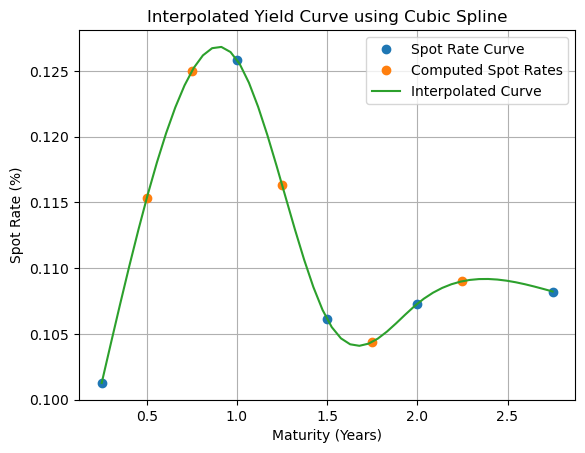

In [12]:
r_k = [r1, r2, r3, r4, r5]
r_l = [r6, r7, r8, r9, r10]

t_linspace = np.linspace(0.25, 2.75)
r_interp = CubicSpline(k, r_k, bc_type="natural")(t_linspace)

plt.plot(k, r_k, 'o', label='Spot Rate Curve')
plt.plot(l, r_l, 'o', label='Computed Spot Rates')
plt.plot(t_linspace, r_interp, label="Interpolated Curve")
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.title('Interpolated Yield Curve using Cubic Spline')
plt.legend()
plt.grid(True)
plt.show()

**Example 1 - Optimized**

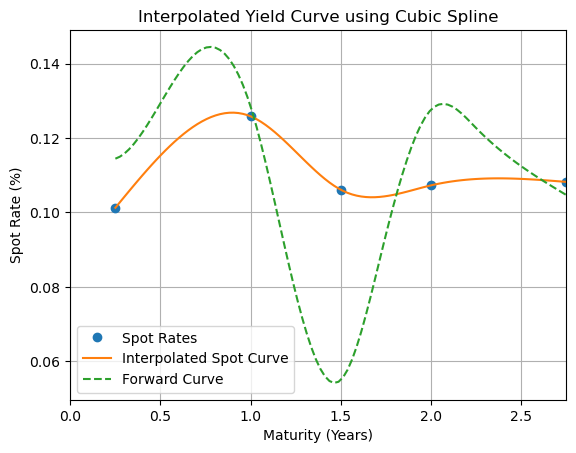

In [13]:
n = [1, 2, 3, 4, 6]
c = [0, 2, 8, 12, 10]
t = [[0.25],
     [0.50, 1.00],
     [0.50, 1.00, 1.50],
     [0.50, 1.00, 1.50, 2.00],
     [0.25, 0.75, 1.25, 1.75, 2.25, 2.75]]
p = [97.5, 90.0, 96.0, 101.6, 99.8]
per = 2

r = {t[i][0]: np.log(100/p[i]) / t[i][0] for i in range(4)}

K = 5
T = np.unique(np.hstack(t)) # list(set().union(*t))
T.sort()
N = len(T)
k =  [t[i][-1] for i in range(K)]
k.sort()
l = list(set(T) - set(k))
l.sort()

def f(r_k):
    cs = CubicSpline(k, r_k, bc_type='natural')  
    r_l = cs(l)
    r.update({timings: rates for timings, rates in zip(k, r_k)})
    r.update({timings: rates for timings, rates in zip(l, r_l)})

    res = []
    for (price, coupon, timings) in zip(p, c, t):
        app_r = [r[i] for i in timings]
        app_r, timings = np.array(app_r), np.array(timings)
        cf = np.full(len(timings), coupon/per)
        cf[-1] += 100
        pv_cf = np.sum(cf * np.exp(-app_r * timings))
        res.append(price - pv_cf)
    
    return res

r_guess = np.append(list(dict.values(r)), np.zeros(K-len(r)))
spots = fsolve(f, r_guess)

spot_mat = np.linspace(0.25, 2.75, 100)
spot_interp = CubicSpline(k, spots, bc_type="natural")(spot_mat)

full_spots = [r[i] for i in T]
forwards = np.array([ ((full_spots[i] * T[i]) - (full_spots[i-1] * T[i-1])) / (T[i] - T[i-1]) for i in range(1, N)])

fwd_mat = np.linspace(0.25, 2.75, 100)
fwd_interp = CubicSpline(T[1:], forwards, bc_type="natural")(fwd_mat)

plt.plot(k, spots, 'o', label='Spot Rates')
plt.plot(spot_mat, spot_interp, label="Interpolated Spot Curve")
plt.plot(fwd_mat, fwd_interp, "--", label="Forward Curve")
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.title('Interpolated Yield Curve using Cubic Spline')
plt.xlim((0,max(k)))
plt.legend()
plt.grid(True)
plt.show()

**Example 2**

[0.10469296 0.10536052 0.10680926 0.10808028]


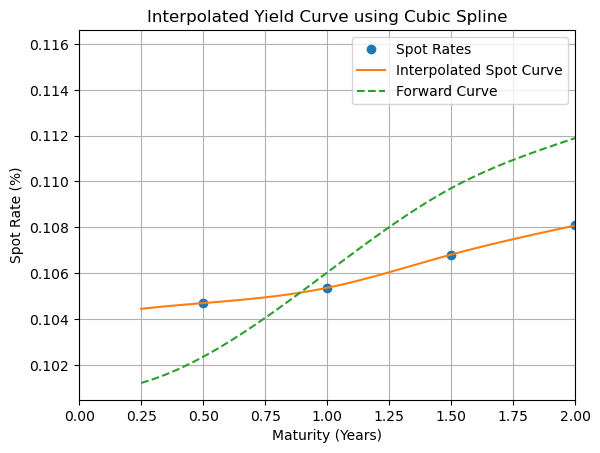

In [14]:
c = [0, 0, 8, 12]
t = [[0.5],
     [1.0],
     [0.5, 1.0, 1.5],
     [0.5, 1.0, 1.5, 2.0]]
p = [94.90, 90.00, 96.00, 101.60]
per = 2

r = {t[i][0]: np.log(100/p[i]) / t[i][0] for i in range(4)}

K = 4
T = np.unique(np.hstack(t)) # list(set().union(*t))
T.sort()
N = len(T)
k =  [t[i][-1] for i in range(K)]
k.sort()
L = N - K 
l = list(set(T) - set(k))
l.sort()


def f(r_k):
    cs = CubicSpline(k, r_k, bc_type='natural')  
    r_l = cs(l)
    r.update({timings: rates for timings, rates in zip(k, r_k)})
    r.update({timings: rates for timings, rates in zip(l, r_l)})

    res = []
    for (price, coupon, timings) in zip(p, c, t):
        app_r = [r[i] for i in timings]
        app_r, timings = np.array(app_r), np.array(timings)
        cf = np.full(len(timings), coupon/per)
        cf[-1] += 100
        pv_cf = np.sum(cf * np.exp(-app_r * timings))
        res.append(price - pv_cf)
    
    return res

r_guess = np.append(list(dict.values(r)), np.zeros(K-len(r)))
spots = fsolve(f, r_guess)
print(spots)

spot_mat = np.linspace(0.25, 2.75, 100)
spot_interp = CubicSpline(k, spots, bc_type="natural")(spot_mat)

full_spots = [r[i] for i in T]
forwards = np.array([ ((full_spots[i] * T[i]) - (full_spots[i-1] * T[i-1])) / (T[i] - T[i-1]) for i in range(1, len(T))])

fwd_mat = np.linspace(0.25, 2.75, 100)
fwd_interp = CubicSpline(T[1:], forwards, bc_type="natural")(fwd_mat)

plt.plot(k, spots, 'o', label='Spot Rates')
plt.plot(spot_mat, spot_interp, label="Interpolated Spot Curve")
plt.plot(fwd_mat, fwd_interp, "--", label="Forward Curve")
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.title('Interpolated Yield Curve using Cubic Spline')
plt.xlim((0,max(k)))
plt.legend()
plt.grid(True)
plt.show()

**Example 3**

In [15]:
n = [1, 1, 1, 1, 4, 8, 15, 36]
c = [0, 0, 0, 0, 12.05, 11.45, 10.74, 10.64]
t = [[0.08],
     [0.25],
     [0.50],
     [1.00],
     [i for i in np.arange(0.5, 2.5, 0.5)],
     [i for i in np.arange(0.5, 4.5, 0.5)],
     [i for i in np.arange(0.5, 8, 0.5)],
     [i for i in np.arange(0.5, 18.5, 0.5)]]
p = [98.93, 96.81, 93.87, 88.66, 100, 100, 100, 100]
per = 2 # Coupon frequency

r = {t[i][0]: np.log(100/p[i]) / t[i][0] for i in range(4)}

# K - Number of Bonds & Number of nonlinear equations formed using bond price function
K = 8
# T - Distinct time points at which a coupon and/or face value payment is made
T = np.unique(np.hstack(t)) # list(set().union(*t))
T.sort()
# N - Total number of distinct times at which coupons and/or face value are paid & Total number of equations
N = len(T)
# k - Set of Maturities of the K bonds, len(k) == K
k =  [t[i][-1] for i in range(K)]
k.sort()
# L - Number of linear equations formed using natural cubic spline interpolation
L = N - K # K non-linear equations, L linear equations (cubic spline), and N number of equations
# l - Set of time points where interpolation is necessary
l = list(set(T) - set(k))
l.sort()

# Step 1: Define x and y values
x_k = np.array(k)
x_l = np.array(l)

# Step 2: Define the equations for solving
def f(r_k):
    # Calculate the spline interpolated values
    cs = CubicSpline(x_k, r_k, bc_type='natural')  
    r_l = cs(x_l)
    # Assigned interest rates to each element of t: (x_k to r_k) + (x_l to r_l)
    r.update({timings: rates for timings, rates in zip(x_k, r_k)})
    r.update({timings: rates for timings, rates in zip(x_l, r_l)})
    
    # Non-linear equation - Results of given price minus spot rate computed price should equal 0
    res = []
    import operator
    for (price, coupon, timings) in zip(p, c, t):
        get = operator.itemgetter(*timings)
        app_r = get(r)
        app_r, timings = np.array(app_r), np.array(timings)
        cf = np.full(len(timings), coupon/per)
        cf[-1] += 100
        pv_cf = np.sum(cf * np.exp(-app_r * timings))
        res.append(price - pv_cf)
    return res

# Step 3: Solve the system of equations
y_guess = np.append(list(dict.values(r)), np.zeros(K-len(r)))
solution = fsolve(f, y_guess)

print(solution)
print(r)

# Forward Rate Calculation - Using Approximation Formula f_t1t2 = [(r_t0t2 * t2) - (r_t01 * t1)] / (t2 - t1)
spots = [r[i] for i in T]
forwards = np.array([ ((spots[i] * T[i]) - (spots[i-1] * T[i-1])) / (T[i] - T[i-1]) for i in range(1, len(T))])
print(forwards)

[0.13447071 0.12967957 0.12651868 0.12036136 0.11672696 0.1103297
 0.10240416 0.10357446]
{0.08: np.float64(0.1344707081620012), 0.25: np.float64(0.12967956502444486), 0.5: np.float64(0.12651867927838173), 1.0: np.float64(0.12036135667118394), np.float64(2.0): np.float64(0.11672695573098511), np.float64(4.0): np.float64(0.11032970044562437), np.float64(7.5): np.float64(0.10240415639089699), np.float64(18.0): np.float64(0.1035744619182917), np.float64(1.5): np.float64(0.11734309495459438), np.float64(2.5): np.float64(0.11578030322928108), np.float64(3.0): np.float64(0.11419766459665945), np.float64(3.5): np.float64(0.11228035770986047), np.float64(4.5): np.float64(0.10859264381689251), np.float64(5.0): np.float64(0.10709867138141073), np.float64(5.5): np.float64(0.10582289983312601), np.float64(6.0): np.float64(0.10474044586598531), np.float64(6.5): np.float64(0.10382642617393559), np.float64(7.0): np.float64(0.10305595745092383), np.float64(8.0): np.float64(0.10184954258518444), np.flo

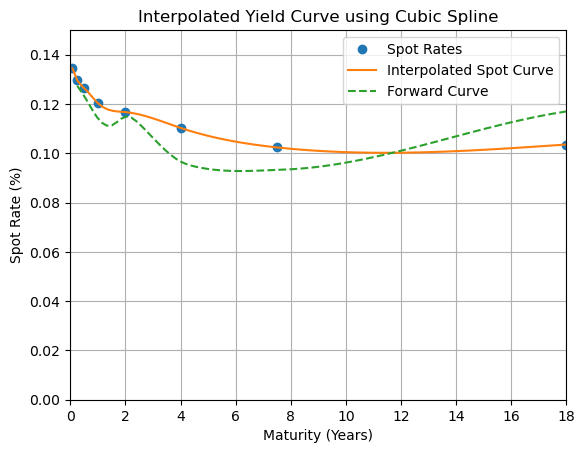

In [16]:
n = [1, 1, 1, 1, 4, 8, 15, 36]
c = [0, 0, 0, 0, 12.05, 11.45, 10.74, 10.64]
t = [[0.08],
     [0.25],
     [0.50],
     [1.00],
     [i for i in np.arange(0.5, 2.5, 0.5)],
     [i for i in np.arange(0.5, 4.5, 0.5)],
     [i for i in np.arange(0.5, 8, 0.5)],
     [i for i in np.arange(0.5, 18.5, 0.5)]]
p = [98.93, 96.81, 93.87, 88.66, 100, 100, 100, 100]
per = 2

r = {t[i][0]: np.log(100/p[i]) / t[i][0] for i in range(4)}

K = 8
T = np.unique(np.hstack(t)) # list(set().union(*t))
T.sort()
N = len(T)
k =  [t[i][-1] for i in range(K)]
k.sort()
L = N - K 
l = list(set(T) - set(k))
l.sort()


def f(r_k):
    cs = CubicSpline(k, r_k, bc_type='natural')  
    r_l = cs(l)
    r.update({timings: rates for timings, rates in zip(k, r_k)})
    r.update({timings: rates for timings, rates in zip(l, r_l)})

    res = []
    for (price, coupon, timings) in zip(p, c, t):
        app_r = [r[i] for i in timings]
        app_r, timings = np.array(app_r), np.array(timings)
        cf = np.full(len(timings), coupon/per)
        cf[-1] += 100
        pv_cf = np.sum(cf * np.exp(-app_r * timings))
        res.append(price - pv_cf)
    
    return res

r_guess = np.append(list(dict.values(r)), np.zeros(K-len(r)))
spots = fsolve(f, r_guess)

spot_mat = np.linspace(0.08, 18, 100)
spot_interp = CubicSpline(k, spots, bc_type="natural")(spot_mat)

full_spots = [r[i] for i in T]
forwards = np.array([ ((full_spots[i] * T[i]) - (full_spots[i-1] * T[i-1])) / (T[i] - T[i-1]) for i in range(1, len(T))])

fwd_mat = np.linspace(0.25, 18, 100)
fwd_interp = CubicSpline(T[1:], forwards, bc_type="natural")(fwd_mat)

plt.plot(k, spots, 'o', label='Spot Rates')
plt.plot(spot_mat, spot_interp, label="Interpolated Spot Curve")
plt.plot(fwd_mat, fwd_interp, "--", label="Forward Curve")
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.title('Interpolated Yield Curve using Cubic Spline')
plt.xlim((0,max(k)))
plt.ylim((0,0.15))
plt.legend()
plt.grid(True)
plt.show()

**Example 4**

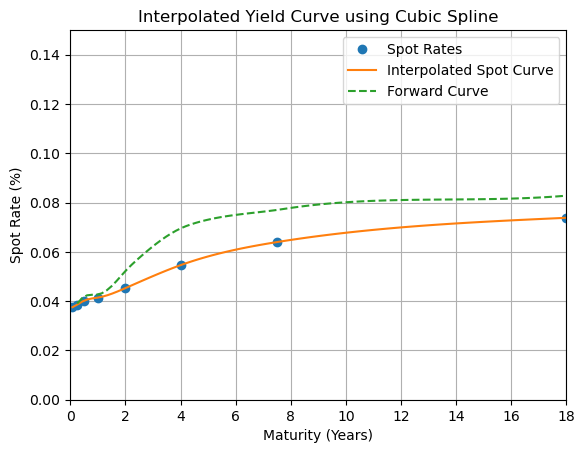

In [17]:
n = [1, 1, 1, 1, 4, 8, 15, 36]
c = [0, 0, 0, 0, 4.57, 5.47, 6.33, 7.12]
t = [[0.08],
     [0.25],
     [0.50],
     [1.00],
     [i for i in np.arange(0.5, 2.5, 0.5)],
     [i for i in np.arange(0.5, 4.5, 0.5)],
     [i for i in np.arange(0.5, 8, 0.5)],
     [i for i in np.arange(0.5, 18.5, 0.5)]]
p = [99.7, 99.04, 98.01, 95.94, 100, 100, 100, 100]
per = 2

r = {t[i][0]: np.log(100/p[i]) / t[i][0] for i in range(4)}

K = 8
T = np.unique(np.hstack(t)) # list(set().union(*t))
T.sort()
N = len(T)
k =  [t[i][-1] for i in range(K)]
k.sort()
L = N - K 
l = list(set(T) - set(k))
l.sort()


def f(r_k):
    cs = CubicSpline(k, r_k, bc_type='natural')  
    r_l = cs(l)
    r.update({timings: rates for timings, rates in zip(k, r_k)})
    r.update({timings: rates for timings, rates in zip(l, r_l)})

    res = []
    for (price, coupon, timings) in zip(p, c, t):
        app_r = [r[i] for i in timings]
        app_r, timings = np.array(app_r), np.array(timings)
        cf = np.full(len(timings), coupon/per)
        cf[-1] += 100
        pv_cf = np.sum(cf * np.exp(-app_r * timings))
        res.append(price - pv_cf)
    
    return res

r_guess = np.append(list(dict.values(r)), np.zeros(K-len(r)))
spots = fsolve(f, r_guess)

spot_mat = np.linspace(0.08, 18, 100)
spot_interp = CubicSpline(k, spots, bc_type="natural")(spot_mat)

full_spots = [r[i] for i in T]
forwards = np.array([ ((full_spots[i] * T[i]) - (full_spots[i-1] * T[i-1])) / (T[i] - T[i-1]) for i in range(1, len(T))])

fwd_mat = np.linspace(0.25, 18, 100)
fwd_interp = CubicSpline(T[1:], forwards, bc_type="natural")(fwd_mat)

plt.plot(k, spots, 'o', label='Spot Rates')
plt.plot(spot_mat, spot_interp, label="Interpolated Spot Curve")
plt.plot(fwd_mat, fwd_interp, "--", label="Forward Curve")
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.title('Interpolated Yield Curve using Cubic Spline')
plt.xlim((0,max(k)))
plt.ylim((0,0.15))
plt.legend()
plt.grid(True)
plt.show()

**Example 5**

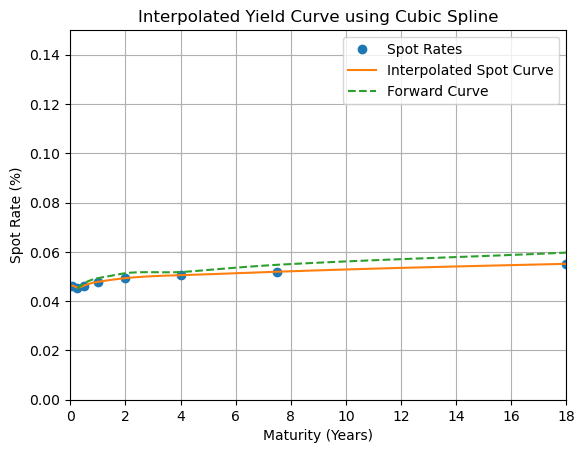

In [18]:
n = [1, 1, 1, 1, 4, 8, 15, 36]
c = [0, 0, 0, 0, 4.99, 5.11, 5.24, 5.5]
t = [[0.08],
     [0.25],
     [0.50],
     [1.00],
     [i for i in np.arange(0.5, 2.5, 0.5)],
     [i for i in np.arange(0.5, 4.5, 0.5)],
     [i for i in np.arange(0.5, 8, 0.5)],
     [i for i in np.arange(0.5, 18.5, 0.5)]]
p = [99.63, 98.87, 97.71, 95.33, 100, 100, 100, 100]
per = 2

r = {t[i][0]: np.log(100/p[i]) / t[i][0] for i in range(4)}

K = 8
T = np.unique(np.hstack(t)) # list(set().union(*t))
T.sort()
N = len(T)
k =  [t[i][-1] for i in range(K)]
k.sort()
L = N - K 
l = list(set(T) - set(k))
l.sort()


def f(r_k):
    cs = CubicSpline(k, r_k, bc_type='natural')  
    r_l = cs(l)
    r.update({timings: rates for timings, rates in zip(k, r_k)})
    r.update({timings: rates for timings, rates in zip(l, r_l)})

    res = []
    for (price, coupon, timings) in zip(p, c, t):
        app_r = [r[i] for i in timings]
        app_r, timings = np.array(app_r), np.array(timings)
        cf = np.full(len(timings), coupon/per)
        cf[-1] += 100
        pv_cf = np.sum(cf * np.exp(-app_r * timings))
        res.append(price - pv_cf)
    
    return res

r_guess = np.append(list(dict.values(r)), np.zeros(K-len(r)))
spots = fsolve(f, r_guess)

spot_mat = np.linspace(0.08, 18, 100)
spot_interp = CubicSpline(k, spots, bc_type="natural")(spot_mat)

full_spots = [r[i] for i in T]
forwards = np.array([ ((full_spots[i] * T[i]) - (full_spots[i-1] * T[i-1])) / (T[i] - T[i-1]) for i in range(1, len(T))])

fwd_mat = np.linspace(0.25, 18, 100)
fwd_interp = CubicSpline(T[1:], forwards, bc_type="natural")(fwd_mat)

plt.plot(k, spots, 'o', label='Spot Rates')
plt.plot(spot_mat, spot_interp, label="Interpolated Spot Curve")
plt.plot(fwd_mat, fwd_interp, "--", label="Forward Curve")
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.title('Interpolated Yield Curve using Cubic Spline')
plt.xlim((0,max(k)))
plt.ylim((0,0.15))
plt.legend()
plt.grid(True)
plt.show()

#### Analysis

As is necessary for any reasonable yield curve estimation methodology, all forward rate curves exhibit a fair degree of smoothness. This is in contrast to some other methodologies, e.g., McCulloch, where forward rate curves exhibit “knuckles” and undesirable asymptotic properties.

In this section we have described a Richard Deaves and Mahmut Parlar's technique for operationalizing the bootstrap methodology for estimating the yield curve given any available data set of bond yields. The problems of illiquidity and missing data points must always be confronted. Illiquidity can be tackled by using some sort of **smoothing technique** (either before or after the bootstrap) or **averaged yield data** (data on four Canadian T-bills and four synthetic par bonds, whose yields were calculated as averages over all bonds in the neighborhood of the relevant maturity.). In the illustration of our methodology using Canadian bond data we employed averaged yields. Missing data points were dealt with by the use of spline interpolation. More specifically, the cubic spline was selected as it provides sufficient flexibility to ensure that the interpolant is continuously differentiable and has continuous second derivatives. We used SciPy's `fsolve()` optimization algorithm to solve the root for a function wherein an interpolation equation is used to solve (reduce) for the missing data points and solve the nonlinear bond pricing equation system in order to obtain the points on the yield curve.

The three examples presented here demonstrate the usefulness of the methodology. The yield curves resulting from the estimation appear to have reasonable shapes, and in addition the forward rate curves are clearly well-behaved as well. Finally, another strength of our methodology is its ease of implementation.

### Polynomial Spline & Exponential Spline Method

### Nelson & Siegel - Parsimonious Modeling of Yield Curves

### References

- [A generalized bootstrap method to determine the yield curve](https://www.tandfonline.com/doi/abs/10.1080/13504860010021162)
- [Bootstrapping Zero Curves - Rebrained!](https://rebrained.com/?p=23)
- [Bootstrapping (Finance) - Wikipedia](https://en.wikipedia.org/wiki/Bootstrapping_%28finance%29)

#### Interpolation and Polynomial Approximation

##### Natural Cubic Spline Interpolation

1.7999999999999998
1.7999999999999998

CSI(1.6) = 1.5119999999999998
[[ 0.75 -0.75]
 [ 0.    2.25]
 [-2.75 -0.5 ]
 [ 3.    1.  ]]
CSI(0) (1 <= x <= 2) = 3.0 + -2.75 (x-1) + 0.0 (x-1)^2  + 0.75 (x-1)^3
CSI (1.6) = 1.512


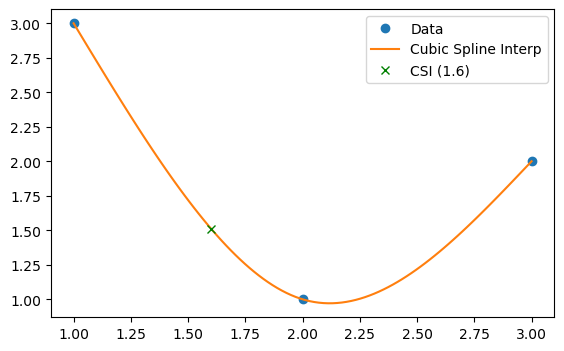

In [19]:
# 3 data points (1, 3), (2, 1), (3, 2)
x = np.array([1,2,3])
y = np.array([3,1,2])

# calculate linear interpolation for 3 points
# produces a convex combination of the nearest neighboring points.
print(interp1d(x,y)(1.6))
print(np.interp(1.6, x, y))
print()

# calculate 2 (n - 1) natural cubic spline polynomials for 3 points 
# provides a smooth (i.e., differentiable) fit to the available data points when the degree of the piecewise polynomial approximation is d = 3.
# produces a linear combination of all y results. 
# This result has the important implication that even with cubic spline interpolation, for a given value of the independent
# variable x, the point on the interpolated curve is obtained as a linear function of the symbolic data points.
cs = CubicSpline(x, y, bc_type='natural')
print("CSI(1.6) =", cs(1.6))

# Coefficients of the polynomials on each segment
print(cs.c)

# Polynomial coefficients for 1 <= x <= 2
a0 = cs.c[3,0]
b0 = cs.c[2,0]
c0 = cs.c[1,0]
d0 = cs.c[0,0]

# Polynomial equation for different 1 <= x <= 2 region
print('CSI(0) (1 <= x <= 2) =', a0, '+', b0, '(x-1) +', c0, '(x-1)^2  +', d0, '(x-1)^3')
cs16 = a0 + (b0*0.6) + (c0*(0.6**2)) + (d0*(0.6**3))
print("CSI (1.6) =", cs16)


xs = np.linspace(1,3, 100)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='Data')
ax.plot(xs, cs(xs), label="Cubic Spline Interp")
ax.plot(1.6, cs(1.6), 'gx', label='CSI (1.6)')
ax.legend(loc='upper right', ncol=1)
plt.show()

CSI(1.6) = 1.5119999999999998
[[ 0.75 -0.75]
 [ 0.    2.25]
 [-2.75 -0.5 ]
 [ 3.    1.  ]]
CSI(0) (1 <= x <= 2) = 3.0 + -2.75 (x-1) + 0.0 (x-1)^2  + 0.75 (x-1)^3
CSI (1.6) = 1.5119999999999998


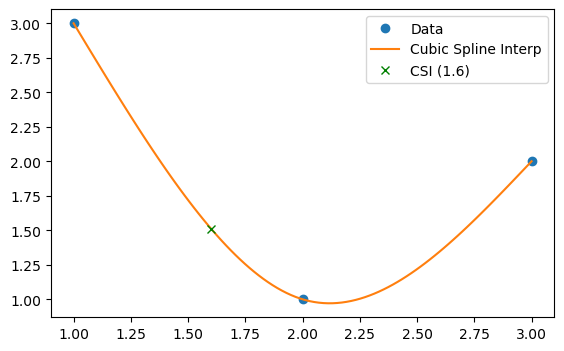

In [20]:
# 3 data points (1, 3), (2, 1), (3, 2)
x = np.array([1,2,3])
y = np.array([3,1,2])

# calculate 2 (n - 1) natural cubic spline polynomials for 3 points 
# provides a smooth (i.e., differentiable) fit to the available data points when the degree of the piecewise polynomial approximation is d = 3
cs = CubicSpline(x, y, bc_type='natural')
print("CSI(1.6) =", cs(1.6))

# Coefficients of the polynomials on each segment
print(cs.c)
# Expected:
# [0.75  -0.75]
# [-2.25  6.75]
# [-0.5  -18.5]
# [5        17]

# Polynomial coefficients for 1 <= x <= 2
a0 = cs.c[3,0]
b0 = cs.c[2,0]
c0 = cs.c[1,0]
d0 = cs.c[0,0]

# c[k, i] is a coefficient for (x-x[i])**(3-k) on the segment between x[i] and x[i+1]

# Polynomial equation for different 1 <= x <= 2 region
print('CSI(0) (1 <= x <= 2) =', a0, '+', b0, '(x-1) +', c0, '(x-1)^2  +', d0, '(x-1)^3')
cs16 = (a0 * (1.6 - 1)**(3-3)) + (b0 * (1.6 - 1)**(3-2)) + (c0 * (1.6 - 1)**(3-1)) + (d0 * (1.6 - 1)**(3-0)) 
print("CSI (1.6) =", cs16)

xs = np.linspace(1,3, 100)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='Data')
ax.plot(xs, cs(xs), label="Cubic Spline Interp")
ax.plot(1.6, cs(1.6), 'gx', label='CSI (1.6)')
ax.legend(loc='upper right', ncol=1)
plt.show()

In [21]:
# Using SciPy's `make_interp_spline` function:
cs_Bspline = make_interp_spline(x, y, k=3, bc_type='natural')
print(cs_Bspline(1.6))
print(cs_Bspline.c)

1.512
[3.         2.08333333 0.25       1.41666667 2.        ]


[[ 0.75 -0.75]
 [ 0.    2.25]
 [-2.75 -0.5 ]
 [ 3.    1.  ]]
CSI(1.6) = 1.1119999999999999
CSI(0) (2 <= x <= 3) = 1.0 + -0.49999999999999994 (x-2) + 2.25 (x-2)^2  + -0.7500000000000002 (x-2)^3
CSI (1.6) = 1.1119999999999999


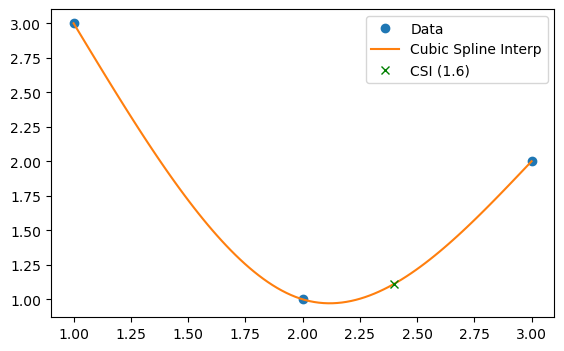

In [22]:
x = np.array([1,2,3])
y = np.array([3,1,2])

cs = CubicSpline(x, y, bc_type='natural')
print(cs.c)

print("CSI(1.6) =", cs(2.4))

# Polynomial coefficients for 2 <= x <= 3
a0 = cs.c[3,1]
b0 = cs.c[2,1]
c0 = cs.c[1,1]
d0 = cs.c[0,1]

# c[k, i] is a coefficient for (x-x[i])**(3-k) on the segment between x[i] and x[i+1]

# Polynomial equation for different 2 <= x <= 3 region
print('CSI(0) (2 <= x <= 3) =', a0, '+', b0, '(x-2) +', c0, '(x-2)^2  +', d0, '(x-2)^3')
cs16 = (a0 * (2.4 - 2)**(3-3)) + (b0 * (2.4 - 2)**(3-2)) + (c0 * (2.4 - 2)**(3-1)) + (d0 * (2.4 - 2)**(3-0)) 
print("CSI (1.6) =", cs16)

xs = np.linspace(1,3, 100)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='Data')
ax.plot(xs, cs(xs), label="Cubic Spline Interp")
ax.plot(2.4, cs(2.4), 'gx', label='CSI (1.6)')
ax.legend(loc='upper right', ncol=1)
plt.show()

[[-0.00368249  0.00604395 -0.00236146]
 [ 0.         -0.00552373  0.00354219]
 [ 0.0052105   0.00244864  0.00145787]
 [ 0.02010067  0.02224561  0.02284449]]


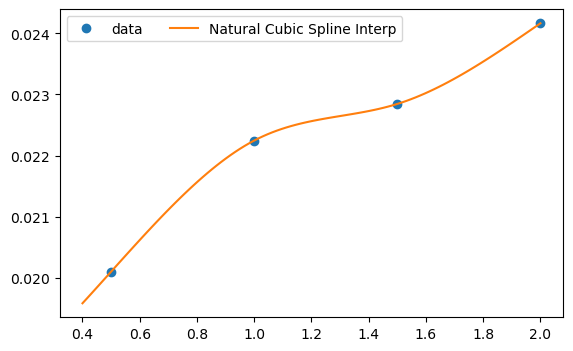

In [23]:
x = np.array([0.5, 1. , 1.5, 2. ])
y = np.array([0.02010067, 0.02224561, 0.02284449, 0.02416379])

# Boundary condition type = 'natural' (The second derivative at curve ends are zero.)
cs = CubicSpline(x, y, bc_type='natural')

print(cs.c)

xs = np.linspace(0.4,2, 100)

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='data')
ax.plot(xs, cs(xs), label="Natural Cubic Spline Interp")
ax.legend(loc='upper left', ncol=2)
plt.show()

[[ 0.00302197  0.00302197  0.00302197]
 [-0.00762508 -0.00309212  0.00144084]
 [ 0.00734693  0.00198833  0.00116269]
 [ 0.02010067  0.02224561  0.02284449]]


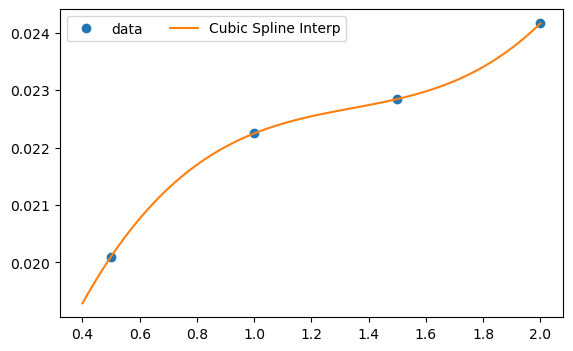

In [24]:
x = np.array([0.5, 1. , 1.5, 2. ])
y = np.array([0.02010067, 0.02224561, 0.02284449, 0.02416379])

# Boundary condition type = not-a-knot (The first and second segment at a curve end are the same polynomial. 
# It is a good default when there is no information on boundary conditions.)
cs = CubicSpline(x, y)

print(cs.c)

xs = np.linspace(0.4,2,100)

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='data')
ax.plot(xs, cs(xs), label="Cubic Spline Interp")
ax.legend(loc='upper left', ncol=2)
plt.show()

In [25]:
# calculate 5 natural cubic spline polynomials for 6 points
# (x,y) = (0,12) (1,14) (2,22) (3,39) (4,58) (5,77)
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([12,14,22,39,58,77])

# calculate natural cubic spline polynomials
cs = CubicSpline(x,y,bc_type='natural')

# show values of interpolation function at x=1.25
print('S(1.25) = ', cs(1.25))
print()

## Additional - find polynomial coefficients for different x regions

# if you want to print polynomial coefficients in form
# S0(0<=x<=1) = a0 + b0(x-x0) + c0(x-x0)^2 + d0(x-x0)^3
# S1(1< x<=2) = a1 + b1(x-x1) + c1(x-x1)^2 + d1(x-x1)^3
# ...
# S4(4< x<=5) = a4 + b4(x-x4) + c5(x-x4)^2 + d5(x-x4)^3
# x0 = 0; x1 = 1; x4 = 4; (start of x region interval)

# show values of a0, b0, c0, d0, a1, b1, c1, d1 ...
print(np.round(cs.c,2))
print()

# Polynomial coefficients for 0 <= x <= 1
a0 = cs.c.item(3,0)
b0 = cs.c.item(2,0)
c0 = cs.c.item(1,0)
d0 = cs.c.item(0,0)

# Polynomial coefficients for 1 < x <= 2
a1 = cs.c.item(3,1)
b1 = cs.c.item(2,1)
c1 = cs.c.item(1,1)
d1 = cs.c.item(0,1)

# ...

# Polynomial coefficients for 4 < x <= 5
a4 = cs.c.item(3,4)
b4 = cs.c.item(2,4)
c4 = cs.c.item(1,4)
d4 = cs.c.item(0,4)

# Print polynomial equations for different x regions
print('S0(0 <= x <= 1) =', round(a0), '+', round(b0), '(x-0) +', round(c0), '(x-0)^2  +', round(d0), '(x-0)^3')
print('S1(1 < x <= 2) =', round(a1), '+', round(b1), '(x-1) +', round(c1), '(x-1)^2  +', round(d1), '(x-1)^3')
print('...')
print('S5(4 < x <= 5) =', round(a4), '+', round(b4), '(x-4) +', round(c4), '(x-4)^2  +', round(d4), '(x-4)^3')
print()

# So we can calculate S(1.25) by using equation S1(1 < x <=2)
print('S(1.25) =', a1 + b1*0.25 + c1*(0.25**2) + d1*(0.25**3))

# Cubic spline interpolation calculus example
    #  https://www.youtube.com/watch?v=gT7F3TWihvk
    #  https://www.youtube.com/watch?v=yOUst2672qo

S(1.25) =  15.203125

[[ 1.  1. -2.  0.  0.]
 [-0.  3.  6.  0.  0.]
 [ 1.  4. 13. 19. 19.]
 [12. 14. 22. 39. 58.]]

S0(0 <= x <= 1) = 12 + 1 (x-0) + 0 (x-0)^2  + 1 (x-0)^3
S1(1 < x <= 2) = 14 + 4 (x-1) + 3 (x-1)^2  + 1 (x-1)^3
...
S5(4 < x <= 5) = 58 + 19 (x-4) + 0 (x-4)^2  + 0 (x-4)^3

S(1.25) = 15.203125


In [26]:
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([12,14,22,39,58,77])

cs = CubicSpline(x,y,bc_type='natural')

print('S(0.5) = ', cs(0.5))
print()

print(np.round(cs.c,2))
print()

# Polynomial coefficients for 0 <= x <= 1
a0 = cs.c.item(3,0)
b0 = cs.c.item(2,0)
c0 = cs.c.item(1,0)
d0 = cs.c.item(0,0)

# Polynomial coefficients for 1 < x <= 2
a1 = cs.c.item(3,1)
b1 = cs.c.item(2,1)
c1 = cs.c.item(1,1)
d1 = cs.c.item(0,1)

# ...

# Polynomial coefficients for 4 < x <= 5
a4 = cs.c.item(3,4)
b4 = cs.c.item(2,4)
c4 = cs.c.item(1,4)
d4 = cs.c.item(0,4)

print('S0 (0 <= x <= 1) =', round(a0), '+', round(b0), '(x-0) +', round(c0), '(x-0)^2  +', round(d0), '(x-0)^3')
print('S1 (1 < x <= 2) =', round(a1), '+', round(b1), '(x-1) +', round(c1), '(x-1)^2  +', round(d1), '(x-1)^3')
print('...')
print('S5 (4 < x <= 5) =', round(a4), '+', round(b4), '(x-4) +', round(c4), '(x-4)^2  +', round(d4), '(x-4)^3')
print()

print('S(0.5) =', a0 + b0*0.5 + c0*(0.5**2) + d0*(0.5**3))

S(0.5) =  12.625

[[ 1.  1. -2.  0.  0.]
 [-0.  3.  6.  0.  0.]
 [ 1.  4. 13. 19. 19.]
 [12. 14. 22. 39. 58.]]

S0 (0 <= x <= 1) = 12 + 1 (x-0) + 0 (x-0)^2  + 1 (x-0)^3
S1 (1 < x <= 2) = 14 + 4 (x-1) + 3 (x-1)^2  + 1 (x-1)^3
...
S5 (4 < x <= 5) = 58 + 19 (x-4) + 0 (x-4)^2  + 0 (x-4)^3

S(0.5) = 12.625


##### Quartic Spline

The interpolation method that guarantees the smoothest interpolation of the continuous instantaneous forward rates is a quartic spline of that continuous forward curve.

A quartic spline is a piecewise polynomial function of degree 4 that is commonly used for smooth interpolation between points. In Python, implementing a quartic spline requires setting up and solving a system of equations for continuity, smoothness, and boundary conditions at each segment.

As before, suppose $t_{1}, t_{2},\cdots, t_{n}$ and $f_{1}, f_{2},\cdots, f_{n}, f_{i}:=f(t_{i})$ are known. To complete the requisite spline for $f$, we desire coefficients $(a_{i}, b_{i}, c_{i}, d_{i}, e_{i})$ for $1\le i\le n-1$. Given these coefficients, the function value at any term $t$ will be
$$f(t) = a_{i} + b_{i}t + c_{i}t^{2} + d_{i}t^{3} + e_{i}t^{4},\space\space t_{i} \le t \le t_{i+1}^{5}$$

Hence

$$f'(t)=b_{i}+2c_{i}t+3d_{i}t^{2}+4e_{i}t^{3}$$
$$f''(t)=2c_{i}+6d_{i}t+12e_{i}t^{2}$$
$$f'''(t)=6d_{i}+24e_{i}t$$

Requiring continuity of all of the above functions gives
$$f_{i} = a_{i} + b_{i}t_{i} + c_{i}t^{2}_{i} + d_{i}t^{3}_{i} + e_{i}t^{4}_{i},\space\space 1 \le t \le -1$$
$$f_{i+1} = a_{i} + b_{i}t_{i+1} + c_{i}t^{2}_{i+1} + d_{i}t^{3}_{i+1} + e_{i}t^{4}_{i+1},\space\space 1 \le t \le -1$$
$$b_{i}+2c_{i}t_{i+1}+3d_{i}t^{2}_{i+1}+4e_{i}t^{3}_{i+1}=b_{i+1}+2c_{i+1}t_{i+1}+3d_{i+1}t^{2}_{i+1}+4e_{i+1}t^{3}_{i+1}, \space\space 1 \le i \le n-2$$
$$2c_{i}+6d_{i}t_{i+1}+12e_{i}t^{2}_{i+1} = 2c_{i+1}+6d_{i+1}t_{i+1}+12e_{i+1}t^{2}_{i+1}, \space\space 1 \le i \le n-2$$
$$6d_{i}+24e_{i}t_{i+1} = 6d_{i+1}+24e_{i+1}t_{i+1}, \space\space 1 \le i \le n-2$$

Thus we have 5n-8 equations in 5n-5 unknowns. Thus, we need three more conditions. The following three conditions are specified in Adams (2001):
$$f'(t_{1})=0$$
$$f''(t_{n})=0$$
$$f'''(t_{n})=0$$

The system is actually a bandwidth matrix with widths 2 and 6. As a banded matrix, we write it in the form suggested in Press et al. (1992, Section 2.4): so a $5(n-1)\times9$ matrix A.

In [27]:
import numpy as np
from scipy.linalg import solve

class QuarticSpline:
    def __init__(self, terms, forward_rates, bc_type='natural'):
        self.terms = np.array(terms)
        self.forward_rates = np.array(forward_rates)
        self.bc_type = bc_type
        self.coefficients = self._compute_coefficients()
    
    def _compute_coefficients(self):
        n = len(self.terms)
        h = np.diff(self.terms)  # Interval widths
        
        # Number of coefficients must equal number of equations
        num_coeffs = 5 * (n - 1)  # 5 coefficients per interval
        
        # Initialize the matrix and right-hand side
        A = np.zeros((num_coeffs, num_coeffs))
        b = np.zeros(num_coeffs)
        
        eq_idx = 0
        
        # For each interval
        for i in range(n-1):
            base = 5 * i
            
            # 1. Function values at left endpoint
            A[eq_idx, base:base+5] = [1, 0, 0, 0, 0]
            b[eq_idx] = self.forward_rates[i]
            eq_idx += 1
            
            # 2. Function values at right endpoint
            A[eq_idx, base:base+5] = [1, h[i], h[i]**2, h[i]**3, h[i]**4]
            b[eq_idx] = self.forward_rates[i+1]
            eq_idx += 1
            
            if i < n-2:  # For all but the last interval
                # 3. First derivative continuity
                A[eq_idx, base:base+5] = [0, 1, 2*h[i], 3*h[i]**2, 4*h[i]**3]
                if base + 5 < num_coeffs:
                    A[eq_idx, base+5:base+10] = [0, -1, 0, 0, 0]
                b[eq_idx] = 0
                eq_idx += 1
                
                # 4. Second derivative continuity
                A[eq_idx, base:base+5] = [0, 0, 2, 6*h[i], 12*h[i]**2]
                if base + 5 < num_coeffs:
                    A[eq_idx, base+5:base+10] = [0, 0, -2, 0, 0]
                b[eq_idx] = 0
                eq_idx += 1
                
                # 5. Third derivative continuity
                A[eq_idx, base:base+5] = [0, 0, 0, 6, 24*h[i]]
                if base + 5 < num_coeffs:
                    A[eq_idx, base+5:base+10] = [0, 0, 0, -6, 0]
                b[eq_idx] = 0
                eq_idx += 1
        
        # Add boundary conditions
        if self.bc_type == 'natural':
            # First derivative = 0 at start
            A[eq_idx, 0:5] = [0, 1, 0, 0, 0]
            b[eq_idx] = 0
            eq_idx += 1
            
            # Second derivative = 0 at end
            last_base = 5 * (n-2)
            A[eq_idx, last_base:last_base+5] = [0, 0, 2, 6*h[-1], 12*h[-1]**2]
            b[eq_idx] = 0
            eq_idx += 1
            
            # Third derivative = 0 at end
            A[eq_idx, last_base:last_base+5] = [0, 0, 0, 6, 24*h[-1]]
            b[eq_idx] = 0
        
        # Add small regularization term to avoid singularity
        A = A + np.eye(num_coeffs) * 1e-10
        
        try:
            coefficients = solve(A, b)
            return coefficients.reshape(-1, 5)
        except np.linalg.LinAlgError:
            raise ValueError("Failed to solve the system. The matrix is singular or poorly conditioned.")
    
    def evaluate(self, x):
        """Evaluate the spline at point x"""
        if x < self.terms[0] or x > self.terms[-1]:
            raise ValueError("x is outside the interpolation range")
            
        # Find the appropriate interval
        i = np.searchsorted(self.terms, x, side='right') - 1
        i = max(min(i, len(self.coefficients) - 1), 0)
        dx = x - self.terms[i]
        
        # Evaluate the polynomial
        coef = self.coefficients[i]
        return coef[0] + coef[1]*dx + coef[2]*dx**2 + coef[3]*dx**3 + coef[4]*dx**4

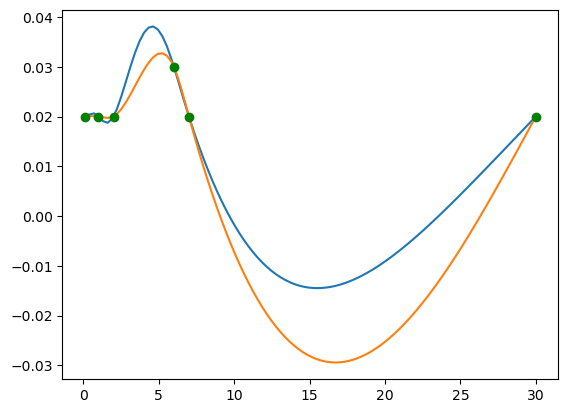

In [39]:
# Usage example
terms = np.array([0.1, 1, 2, 6, 7, 30])
forwards = np.array([0.02, 0.02, 0.02, 0.03, 0.02, 0.02])
forward_spline = QuarticSpline(terms, forwards, bc_type='natural')
cs = CubicSpline(terms, forwards, bc_type='natural')

x_vals = np.linspace(0.1, 30, 100)
y_vals = [forward_spline.evaluate(x) for x in x_vals]

plt.plot(x_vals, y_vals)
plt.plot(x_vals, cs(x_vals))
plt.plot(terms, forwards, "go")

(0.0, 20.0)

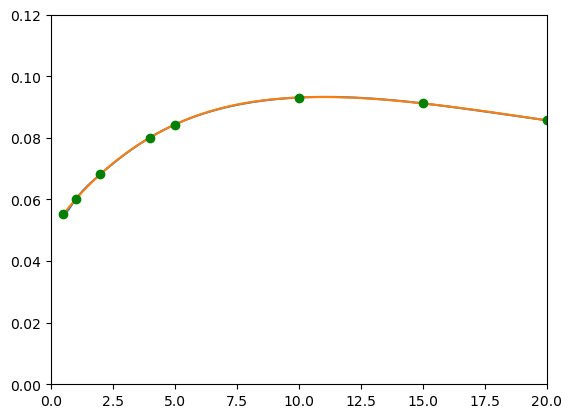

In [42]:
terms = np.array([0.5, 1, 2, 4, 5, 10, 15, 20])
zero_rate = np.array([0.0552, 0.0600, 0.0682, 0.0801, 0.0843, 0.0931, 0.0912, 0.0857])
cs = CubicSpline(terms, zero_rate, bc_type='natural')
qs = QuarticSpline(terms, zero_rate, bc_type='natural')

x_vals = np.linspace(0.5, 20, 100)
y_vals = [qs.evaluate(x) for x in x_vals]

plt.plot(x_vals, y_vals)
plt.plot(x_vals, cs(x_vals))
plt.plot(terms, zero_rate, "go")
plt.ylim(0,0.12)
plt.xlim(0,20)

#### `fsolve()` to Solve Nonlinear Equations

SciPy's optimization package offers an `fsolve()` function which finds the roots of a nonlinear function. As an example, consider the problem where we wish to find the positive solution of the nonlinear system of equations:
$$x^{2} + y^{2} = 1$$  
$$y = e^{(-x)}$$

In [30]:
def f(z):
    x, y = z[0], z[1]
    z1 = x**2 + y**2 - 1
    z2 = y - np.exp(-x)
    return [z1, z2]

x, y = fsolve(f, np.zeros(2))
print(f'{x = }, {y = }')

x = np.float64(0.9165625831005157), y = np.float64(0.39989127429139987)
